In [28]:
import numpy as np
import pandas as pd
import json

import matplotlib 
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns


import time

plt.style.use('seaborn-white')
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'legend.frameon':True})

/tmp/ipykernel_44067/583203746.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
from dataclasses import dataclass


@dataclass
class OutputData:
    features: pd.DataFrame
    output: pd.DataFrame


def get_dataset(path: str):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

In [47]:
json_dataset = get_dataset('./datasets/data_30_000.json')
df = pd.json_normalize(json_dataset)

columns_rename = {
    ## service params
    'inp.services.cv': 'services_cv',
    'inp.services.skew': 'services_skew',
    'inp.services.rate_min': 'services_rate_min',
    'inp.services.rate_max': 'services_rate_max',
    ## arrival params
    'inp.arrival.skew': 'arrival_skew',
    'inp.arrival.cv': 'arrival_cv',
    'inp.arrival.rate': 'arrival_rate',
    ## num servers
    'inp.num_servers': 'num_servers',
    ## capacity
    'inp.capacity': 'capacity',
    ## meta info
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_skew': 'meta_arrival_skew',
    'meta.fitted.arrival_lag': 'meta_arrival_lag',
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_order': 'meta_arrival_order',
    'meta.fitted.service_cv': 'meta_service_cv',
    'meta.fitted.service_skew': 'meta_service_skew',
    'meta.fitted.service_order': 'meta_service_order',
    ## output
    'out.max_system_size.avg': 'out_max_system_size_avg',
    'out.max_system_size.std': 'out_max_system_size_std',
    'out.max_system_size.index': 'out_max_system_size_index',
    'out.min_system_size.avg': 'out_min_system_size_avg',
    'out.min_system_size.std': 'out_min_system_size_std',
    'out.min_system_size.index': 'out_min_system_size_index',
    'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
    'out.max_busy_rate.std': 'out_max_busy_rate_std',
    'out.max_busy_rate.index': 'out_max_busy_rate_index',
    'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
    'out.min_busy_rate.std': 'out_min_busy_rate_std',
    'out.min_busy_rate.index': 'out_min_busy_rate_index',
    'out.loss_prob': 'out_los_prob',
    'out.response_time.avg': 'out_response_time_avg',
    'out.response_time.std': 'out_response_time_std',
    'out.response_time.index': 'out_response_time_index'
}

df = df.rename(columns=columns_rename, inplace=False)
df

data = OutputData(
    features=df[['services_cv', 
                 'services_skew', 
                 'services_rate_min', 
                 'services_rate_max',
                 'arrival_skew',
                 'arrival_cv',
                 'arrival_rate',
                 'num_servers',
                 'capacity'
    ]],
    output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
    ]]
)

## TODO remove input_type and lag from df

In [4]:
COLORS_MAP = {
    'green': ["Greens", 'lightgreen'],
    'blue': ["Blues", 'lightblue'],
    'orange': ["Oranges", "#fed8b1"],
    'purple': ['Purples', '#D8BFD8']
}


def build_estimates_tests_scatter(estimations, predictions,
                                  name="", 
                                  rang=[0, 10], 
                                  divider=1,
                                  xlabel='samples_s', 
                                  ylabel='sstimates_s',
                                  color='blue'):
    
    fig , ax = plt.subplots(figsize=(6, 6))
    cm = plt.get_cmap(COLORS_MAP.get(color)[0])
    col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
    plt.scatter(predictions, estimations, c=col, marker='^')
    x = np.linspace(rang[0], rang[1])
    plt.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
    plt.title('{}'.format(name), fontsize=22, pad=10)
    ax.title.set_fontsize(24)
    plt.xticks()
    plt.tick_params(labelsize=22)
    plt.yticks()

    plt.xlim(rang)
    plt.ylim(rang)

    ax.set_xlabel(xlabel, size=24)
    ax.set_ylabel(ylabel, size=24)

## response time regression

In [5]:
response_time = data.output['out_response_time_avg']
response_time

0          5.851424
1          8.988140
2          3.759917
3         14.444607
4          4.483550
            ...    
29647     82.961335
29648     63.262886
29649    119.267460
29650      2.796008
29651     34.185188
Name: out_response_time_avg, Length: 29652, dtype: float64

In [48]:
data.features

,services_cv,services_skew,services_rate_min,services_rate_max,arrival_skew,arrival_cv,arrival_rate,num_servers,capacity
0,29.41,68.79,91.02,91.96,33.37,3.39,63.65,25,53
1,57.13,97.85,34.98,79.66,76.04,1.60,38.24,8,71
2,16.10,55.67,79.07,89.10,93.61,32.87,51.47,19,64
3,93.01,139.52,85.17,91.51,96.70,32.54,81.58,99,13
4,6.46,41.56,24.55,69.11,63.51,14.15,26.21,31,69
...,...,...,...,...,...,...,...,...,...
29647,50.11,96.94,8.64,49.75,95.52,59.60,7.68,79,60
29648,47.56,89.42,6.31,61.80,97.72,64.01,95.73,65,55
29649,84.45,126.68,10.57,87.26,116.16,77.44,36.92,81,57
29650,10.90,19.88,34.60,66.21,102.33,68.22,33.59,40,11


## Regression tree

In [8]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_params = {
                'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                'max_depth':[4,5,6,7,8,9,10,11,12,15,20]
}

gs = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    tree_params,
    verbose=1,
    cv=10,
    n_jobs=4
)

#regressor = DecisionTreeRegressor(random_state=0)
#cross_val_score(regressor, df, y_busy_services, cv=10)

#gs.fit(df, y_busy_services)

start_time = time.time()
tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=12)
print("Time for calculation decision tree {}".format(time.time() - start_time))

X_train, X_test, y_train, y_test = train_test_split(data.features, response_time, train_size=0.8)

tree.fit(X_train, y_train)
#print(regression_report(y_test, tree.predict(X_test)))

Time for calculation decision tree 2.5033950805664062e-05


DecisionTreeRegressor(criterion='friedman_mse', max_depth=12)

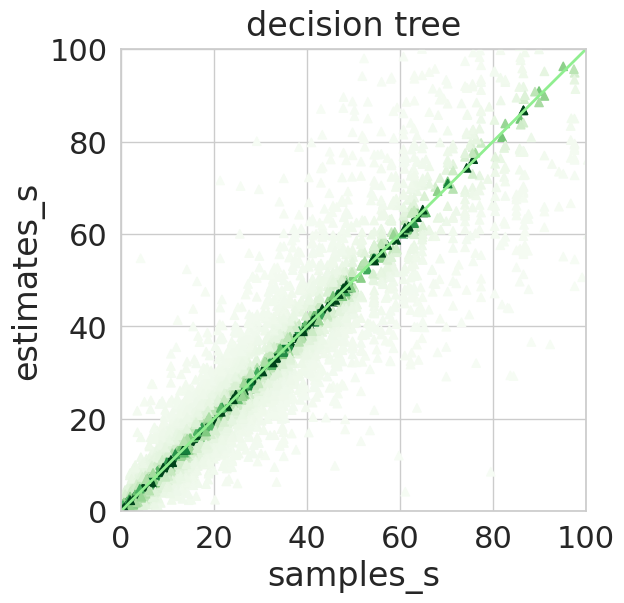

In [14]:
build_estimates_tests_scatter(
    y_test.values,
    tree.predict(X_test), 
    name="decision tree", 
    color="green",
    rang=[0, 100], divider=2, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)

## Gradient boosting

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.features, response_time, train_size=0.7, random_state=42)
#grb_estimation_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(max_depth=18, n_estimators=1000))

grb_estimation_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor())

tree_params = {
    'criterion': ['mse', 'friedman_mse'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 20, 25, 30],
    'n_estimators': [50, 10, 150, 250, 400, 500, 700, 900, 1000, 1200, 1500, 2000]
}

start_time = time.time()
#grb_estimation_pipe.fit(X_train, y_train) 

gs = GridSearchCV(
    grb_estimation_pipe,
    param_grid=tree_params,
    n_jobs=6,
    cv=4
)

gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

#print("Time for calculation gradient boosting {}".format(time.time() - start_time))

ValueError: Invalid parameter 'criterion' for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [50]:
scaler = StandardScaler()
scaler.fit(X_test)
x = scaler.transform(X_test)
print(x)
X_test

[[-1.72730567e+00 -7.39765232e-01 -1.03185630e+00 ...  8.14674145e-01
   1.43394172e+00 -1.38201870e+00]
 [ 3.76924508e-01  5.76440164e-02 -1.53603953e-01 ...  1.09704834e+00
  -6.23017557e-02 -6.57649743e-01]
 [ 4.02373283e-01  4.16239044e-02 -4.45226057e-01 ... -6.28108667e-01
  -1.41935979e+00 -2.26830593e-03]
 ...
 [-1.47630406e+00 -2.50492002e+00 -6.04369615e-01 ... -2.49178468e-01
  -9.70981155e-02  2.04694253e-01]
 [ 2.02930511e-02  6.64121082e-03 -6.39076454e-01 ...  1.01924783e+00
   5.64032721e-01  5.84125612e-01]
 [ 4.03070509e-01  6.71253072e-02  8.21150338e-01 ... -7.50019300e-01
  -1.62813795e+00 -1.48549998e+00]]


,services_cv,services_skew,services_rate_min,services_rate_max,arrival_skew,arrival_cv,arrival_rate,num_servers,capacity
25630,0.57,69.07,9.26,71.92,56.40,8.51,73.67,92,10
27395,60.93,93.46,30.01,78.11,98.49,59.06,81.80,49,31
26852,61.66,92.97,23.12,90.89,61.98,18.47,32.13,10,50
8643,47.70,75.13,59.82,67.71,74.28,43.98,48.50,17,72
26084,13.84,39.33,57.96,64.38,28.22,4.30,40.76,35,9
...,...,...,...,...,...,...,...,...,...
29044,90.51,135.77,30.87,32.85,146.93,97.95,98.28,60,17
13987,78.05,117.08,22.45,97.63,114.72,76.48,1.22,14,97
4417,7.77,15.08,19.36,48.84,102.81,68.54,43.04,48,56
26060,50.70,91.90,18.54,71.74,86.41,52.96,79.56,67,67


In [45]:
data.features

AttributeError: 'list' object has no attribute 'features'

/tmp/ipykernel_44067/4256020693.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]


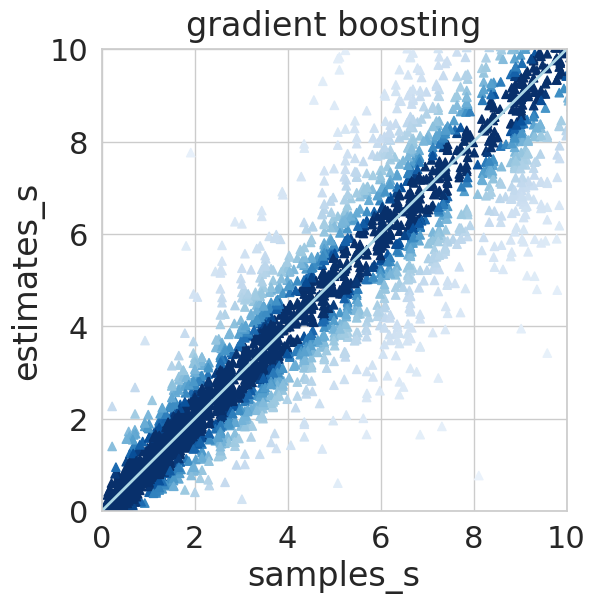

In [27]:
build_estimates_tests_scatter(
    y_test.values,
    tree.predict(X_test), 
    name="gradient boosting", 
    color="blue",
    rang=[0, 10], divider=2, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)